In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as torch
import os
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [264]:
X = pd.read_pickle("X.pkl")

In [265]:
X.head

<bound method NDFrame.head of              PS1         PS2       PS3           PS4       PS5       PS6  \
0     160.673492  109.466914  1.991475  0.000000e+00  9.842170  9.728097   
1     160.603320  109.354890  1.976234  0.000000e+00  9.635142  9.529488   
2     160.347720  109.158845  1.972224  0.000000e+00  9.530548  9.427949   
3     160.188088  109.064807  1.946575  0.000000e+00  9.438827  9.337430   
4     160.000472  108.931434  1.922707  0.000000e+00  9.358762  9.260636   
5     159.920210  108.887682  1.913284  0.000000e+00  9.301160  9.206877   
6     159.672675  108.676466  1.888100  0.000000e+00  9.233942  9.143320   
7     159.614452  108.651745  1.874894  0.000000e+00  9.194159  9.105058   
8     159.475745  108.529738  1.858120  0.000000e+00  9.144616  9.057067   
9     159.437997  108.510885  1.841063  0.000000e+00  9.104831  9.019265   
10    159.321757  108.437852  1.832484  0.000000e+00  9.068217  8.983758   
11    159.235113  108.316782  1.825662  0.000000e+00  9.02

In [266]:
Y = pd.read_pickle("Y.pkl")

In [267]:
Y.head

<bound method NDFrame.head of         0    1  2    3  4
0       3  100  0  130  1
1       3  100  0  130  1
2       3  100  0  130  1
3       3  100  0  130  1
4       3  100  0  130  1
5       3  100  0  130  1
6       3  100  0  130  1
7       3  100  0  130  1
8       3  100  0  130  1
9       3  100  0  130  1
10      3  100  0  130  1
11      3  100  0  130  1
12      3  100  0  130  1
13      3  100  0  130  1
14      3  100  0  130  1
15      3  100  0  130  1
16      3  100  0  130  1
17      3  100  0  130  1
18      3  100  0  130  1
19      3  100  0  130  1
20      3  100  0  130  1
21      3  100  0  130  1
22      3  100  0  130  1
23      3  100  0  130  1
24      3  100  0  130  1
25      3  100  0  130  1
26      3  100  0  130  1
27      3  100  0  130  1
28      3  100  0  130  1
29      3  100  0  130  1
...   ...  ... ..  ... ..
2175  100   80  0   90  0
2176  100   90  0   90  0
2177  100   90  0   90  0
2178  100   90  0   90  0
2179  100   90  0   90  0
2180  10

In [268]:
# stable flag:
# 	0: conditions were stable
# 	1: static conditions might not have been reached yet

In [269]:
target = pd.DataFrame(Y[4])
print(target)

      4
0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
...  ..
2175  0
2176  0
2177  0
2178  0
2179  0
2180  0
2181  0
2182  0
2183  0
2184  0
2185  0
2186  0
2187  0
2188  0
2189  0
2190  0
2191  0
2192  0
2193  0
2194  0
2195  0
2196  0
2197  0
2198  0
2199  0
2200  0
2201  0
2202  0
2203  0
2204  0

[2205 rows x 1 columns]


In [270]:
def build_sequences(features_df, target_df, sequence_length):
    
    """
    Builds sequences from data and converts them into pytorch tensors
    sequence_length - represents the number of samples to be considered in a sequence
    
    """
    data_ = []
    target_ = []
    
    for i in range(int(features_df.shape[0]/sequence_length)):
        
        data = torch.from_numpy(features_df.iloc[i:i+sequence_length].values)
        target = torch.from_numpy(target_df.iloc[i+sequence_length+1].values)
        
        data_.append(data)
        target_.append(target)
        
    data = torch.stack(data_)
    target = torch.stack(target_)
    
    return data, target

In [271]:
sequence_length = 3

features = X
target = target
data, target = build_sequences(features, target, sequence_length=sequence_length)

print(data)
data.shape

tensor([[[160.6735, 109.4669,   1.9915,  ...,  39.6013,   1.8627,  59.1572],
         [160.6033, 109.3549,   1.9762,  ...,  25.7864,   1.2555,  59.3356],
         [160.3477, 109.1588,   1.9722,  ...,  22.2182,   1.1132,  59.5432]],

        [[160.6033, 109.3549,   1.9762,  ...,  25.7864,   1.2555,  59.3356],
         [160.3477, 109.1588,   1.9722,  ...,  22.2182,   1.1132,  59.5432],
         [160.1881, 109.0648,   1.9466,  ...,  20.4598,   1.0622,  59.7949]],

        [[160.3477, 109.1588,   1.9722,  ...,  22.2182,   1.1132,  59.5432],
         [160.1881, 109.0648,   1.9466,  ...,  20.4598,   1.0622,  59.7949],
         [160.0005, 108.9314,   1.9227,  ...,  19.7870,   1.0705,  59.4553]],

        ...,

        [[156.3950, 105.6824,   1.7380,  ...,  22.7522,   1.7663,  59.9804],
         [156.5137, 105.7913,   1.7412,  ...,  27.2730,   2.1196,  59.8352],
         [156.6206, 105.8789,   1.7347,  ...,  27.8870,   2.1560,  59.9289]],

        [[156.5137, 105.7913,   1.7412,  ...,  27.2730

torch.Size([735, 3, 17])

In [272]:
# data.transpose(1,2)
data = data.reshape(735,17,3)
print(data)

tensor([[[1.6067e+02, 1.0947e+02, 1.9915e+00],
         [0.0000e+00, 9.8422e+00, 9.7281e+00],
         [6.7098e+00, 1.0305e+01, 3.5622e+01],
         ...,
         [3.7881e+01, 4.2442e+01, 3.9632e+01],
         [3.5646e+01, 2.5199e+03, 5.7653e-01],
         [2.2218e+01, 1.1132e+00, 5.9543e+01]],

        [[1.6060e+02, 1.0935e+02, 1.9762e+00],
         [0.0000e+00, 9.6351e+00, 9.5295e+00],
         [6.7153e+00, 1.0403e+01, 3.6677e+01],
         ...,
         [3.8879e+01, 4.3404e+01, 4.0403e+01],
         [3.6579e+01, 2.5115e+03, 5.6927e-01],
         [2.0460e+01, 1.0622e+00, 5.9795e+01]],

        [[1.6035e+02, 1.0916e+02, 1.9722e+00],
         [0.0000e+00, 9.5305e+00, 9.4279e+00],
         [6.7185e+00, 1.0366e+01, 3.7881e+01],
         ...,
         [3.9804e+01, 4.4333e+01, 4.1311e+01],
         [3.7428e+01, 2.5034e+03, 5.7737e-01],
         [1.9787e+01, 1.0705e+00, 5.9455e+01]],

        ...,

        [[1.5639e+02, 1.0568e+02, 1.7380e+00],
         [0.0000e+00, 8.5014e+00, 8.4463e+00]

In [273]:
data.shape

torch.Size([735, 17, 3])

In [274]:
print(target)
target.shape

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],

        [1]])


torch.Size([735, 1])

In [275]:
# Train and test data split
test_size = 0.2

indices = torch.randperm(data.shape[0])

train_indices = indices[:int(indices.shape[0] * (1-test_size))]
test_indices = indices[int(indices.shape[0] * (1-test_size)):]

X_train, y_train = data[train_indices], target[train_indices]
X_test, y_test = data[test_indices], target[test_indices]

print(X_train)
X_train.shape

tensor([[[1.5638e+02, 1.0583e+02, 1.6865e+00],
         [1.4113e-02, 8.5137e+00, 8.4560e+00],
         [6.3652e+00, 9.1865e+00, 5.4407e+01],
         ...,
         [5.4442e+01, 5.8981e+01, 5.5895e+01],
         [4.9684e+01, 2.4044e+03, 6.5518e-01],
         [2.0106e+01, 1.5377e+00, 5.7651e+01]],

        [[1.7293e+02, 1.2304e+02, 1.1194e+00],
         [0.0000e+00, 8.4054e+00, 8.3574e+00],
         [3.3081e+00, 8.9130e+00, 5.7159e+01],
         ...,
         [5.7035e+01, 6.0948e+01, 5.8701e+01],
         [5.2514e+01, 2.6083e+03, 7.0423e-01],
         [1.8761e+01, 1.4854e+00, 3.0902e+01]],

        [[1.5622e+02, 1.0524e+02, 1.6380e+00],
         [0.0000e+00, 8.5349e+00, 8.4776e+00],
         [6.2578e+00, 9.1988e+00, 5.4187e+01],
         ...,
         [5.4196e+01, 5.8723e+01, 5.5737e+01],
         [4.9557e+01, 2.4172e+03, 6.6337e-01],
         [2.0029e+01, 1.5305e+00, 5.6289e+01]],

        ...,

        [[1.7280e+02, 1.2266e+02, 1.0735e+00],
         [0.0000e+00, 8.4204e+00, 8.3744e+00]

torch.Size([588, 17, 3])

In [276]:
class Hydraulic_Dataset(torch.utils.data.dataset.Dataset):

    def __init__(self, data, target):
        
        self.data = data
        self.target = target
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [277]:
batch_size = 10

hs_train_dataset = Hydraulic_Dataset(X_train, y_train)
hs_train_loader = torch.utils.data.dataloader.DataLoader(hs_train_dataset, batch_size= batch_size)

hs_test_dataset = Hydraulic_Dataset(X_test, y_test)
hs_test_loader = torch.utils.data.dataloader.DataLoader(hs_test_dataset, batch_size= 1)

In [278]:
class Network(nn.Module):
    def __init__(self, sequence_length, n_features):
        super(Network, self).__init__()
        
        
        self.conv1 = nn.Conv1d(17, 32, kernel_size= 3)
        
        self.lin_in_size = self.conv1.out_channels * int(((sequence_length - (self.conv1.kernel_size[0]-1) -1)/self.conv1.stride[0] +1))
        print(self.lin_in_size)
        
        self.fc1 = nn.Linear(self.lin_in_size,64)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        
        x = F.sigmoid(self.conv1(x))
        x = x.view(-1, self.lin_in_size)
        
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        
        return F.sigmoid(x)

In [279]:
n_features = 17
print(n_features)
net = Network(sequence_length, n_features).double()
net

17
32


Network(
  (conv1): Conv1d(17, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [280]:
lr = 0.01
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [281]:
training_losses = []
training_accuracy=[]
a=[]
b=[]

for epoch in range(10):
    running_loss = 0.0
    batch_accuracy=[]
    batch_losses = []
    for i, (data, target) in enumerate(hs_train_loader):

        optimizer.zero_grad()
        out = net(data)
        loss = criterion(out, target.double())
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()    
        prediction = torch.round(out.data)               
        
        
        a1=prediction.tolist()
        a2=a+a1
        a=a2
        
        b1=target.tolist()
        b2=b+b1
        b=b2
        
        
        total= 0
        correct = 0
        total += target.size(0)  
        out = torch.round(out)
        correct += (out == target).sum().item()
        accuracy = 100 * (correct / total)
        
        batch_accuracy.append(accuracy)
    training_losses.append(np.mean(batch_losses))
    training_accuracy.append(np.mean(batch_accuracy))
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, training_losses[-1], training_accuracy[-1]))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1. Loss: 0.660912556516096. Accuracy: 64.02542372881356
Epoch: 2. Loss: 0.6553575529218818. Accuracy: 64.36440677966101
Epoch: 3. Loss: 0.654219308449228. Accuracy: 64.36440677966101
Epoch: 4. Loss: 0.655947765306709. Accuracy: 64.36440677966101
Epoch: 5. Loss: 0.657048846933518. Accuracy: 64.36440677966101
Epoch: 6. Loss: 0.6565986288105136. Accuracy: 64.36440677966101
Epoch: 7. Loss: 0.6555349887093767. Accuracy: 64.36440677966101
Epoch: 8. Loss: 0.6548051839254312. Accuracy: 64.36440677966101
Epoch: 9. Loss: 0.654485887620739. Accuracy: 64.36440677966101
Epoch: 10. Loss: 0.6543038519249484. Accuracy: 64.36440677966101


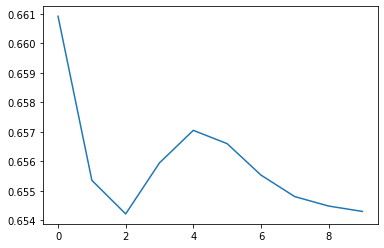

In [282]:
plt.plot(training_losses)

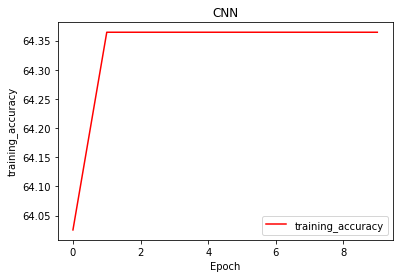

In [283]:
plt.plot(training_accuracy,'r',label = "training_accuracy")
plt.legend()
plt.title('CNN')
plt.xlabel('Epoch')
plt.ylabel('training_accuracy')
plt.show()

In [284]:
import itertools
#Creating list of all outputs and targets obtained after each epoch of training
out=list(itertools.chain.from_iterable(a2))
target=list(itertools.chain.from_iterable(b2))

In [285]:
#Calculation of classification matrix for training
#Creation of classification report for training
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results = confusion_matrix(target, out) 
print ('CNN sigmoid Training Confusion Matrix :')
print(results) 
print ('CNN sigmoid Training Accuracy Score :',accuracy_score(target, out) )
print ('CNN sigmoid Training Report : ')
print (classification_report(target, out))

CNN sigmoid Training Confusion Matrix :
[[3784    6]
 [2086    4]]
CNN sigmoid Training Accuracy Score : 0.64421768707483
CNN sigmoid Training Report : 
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      3790
           1       0.40      0.00      0.00      2090

    accuracy                           0.64      5880
   macro avg       0.52      0.50      0.39      5880
weighted avg       0.56      0.64      0.51      5880



In [286]:
#Defining a function for graphical respresentation of confusion matrix for training 

def plot_confusion_matrix(cm, classes, normalize =False, title = "Confusion Matrix" ):
    print ("Confusion matrix")
    
    print (cm)
    plt.imshow(cm, interpolation='nearest', cmap="Blues")
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(-0.5,len(classes),1)
    plt.xticks(tick_marks, (classes))
    plt.yticks(tick_marks, (classes))
    fmt = "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[3784    6]
 [2086    4]]


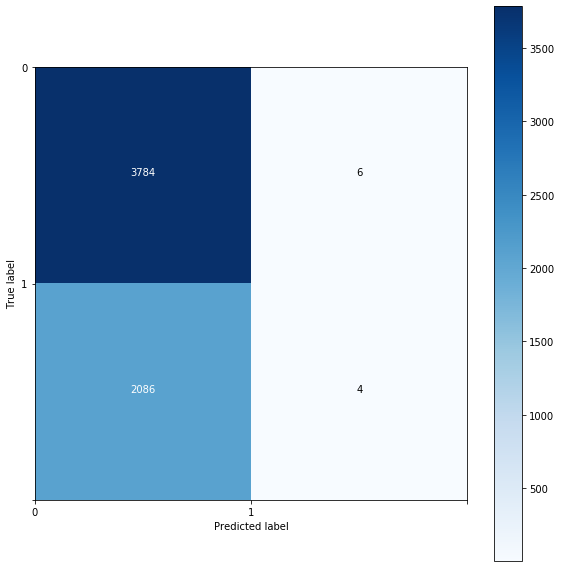

In [287]:
#Graphical respresentation of confusion matrix for training

classes = ['0','1']
plt.figure(figsize=(8,8))
plot_confusion_matrix(results, classes)

In [288]:
targets = []
outputs = []

testing_loss = []
batch_loss = []

testing_accuracy = []
test_batch_accuracy=[]

a_1=[]
b_1=[]


with torch.no_grad():
    for i, (data, target) in enumerate(hs_test_loader):

        out = net(data)
        loss = criterion(out, target.double())
        targets.append(target.item())
        outputs.append(out.item())
        batch_loss.append(loss.item())
        print('Target : {:.4f}, Predicted Output : {:.4f}'.format(target.item(), out.item()))
        prediction = torch.round(out.data)
    
        a3=prediction.tolist()
        a4=a_1+a3
        a_1=a4
        
        b3=target.tolist()
        b4=b_1+b3
        b_1=b4
        
        
        total= 0
        correct = 0
        total += target.size(0)  
        out = torch.round(out)
        correct += (out == target).sum().item()
        accuracy = 100 * (correct / total)
              
    test_batch_accuracy.append(accuracy)
    #mean of loss of all batches => Testing loss        
    testing_loss.append(np.mean(batch_loss))
    # mean accuracy of all batches => Testing accuracy  
    testing_accuracy.append(np.mean(batch_accuracy))
    
print('Loss: {}. Accuracy: {}'.format(testing_loss[-1], testing_accuracy[-1]))

Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 1.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 1.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 1.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 1.0000, Predicted Output : 0.3439
Target : 0.0000, Predicted Output : 0.3439
Target : 0.

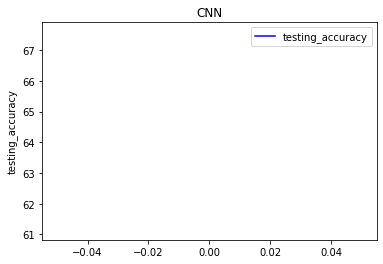

In [289]:
plt.plot(testing_accuracy,'b',label = "testing_accuracy")
plt.legend()
plt.title('CNN')
plt.ylabel('testing_accuracy')
plt.show()

In [290]:
#Creating list of all outputs and targets obtained after testing
predicted1=list(itertools.chain.from_iterable(a4))
targets1=list(itertools.chain.from_iterable(b4))

#Calculation of classification matrix for testing
#Creation of classification report for testing
results1 = confusion_matrix(targets1, predicted1) 
print ('Confusion Matrix :')
print(results1) 
print ('Accuracy Score :',accuracy_score(targets1, predicted1) )
print ('Report : ')
print (classification_report(targets1, predicted1) )

Confusion Matrix :
[[101   0]
 [ 46   0]]
Accuracy Score : 0.6870748299319728
Report : 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.69      1.00      0.81       101
           1       0.00      0.00      0.00        46

    accuracy                           0.69       147
   macro avg       0.34      0.50      0.41       147
weighted avg       0.47      0.69      0.56       147



Confusion matrix
[[101   0]
 [ 46   0]]


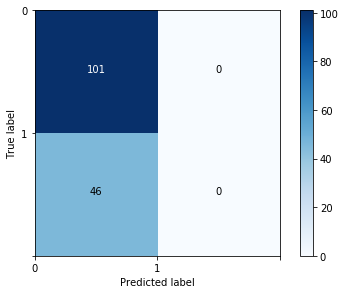

In [291]:
#Graphical respresentation of confusion matrix for testing
plot_confusion_matrix(results1, classes)